In [1]:
import os
from m_generator import get_file_dict
import numpy as np
import torch.nn.functional as F
import torch
import random
import matplotlib.pyplot as plt
import tuneThreshold

In [2]:
npy_list = os.listdir("../libri_emb/")
npy_list = [i for i in npy_list if str.find(i, "npy") != -1]

spk_emb_dict = {}
for emb in npy_list:
    emb_spk = int(emb[3:-4])
    emb_mat = np.load("../libri_emb/"+emb)
    
    # AP + softmax loss의 경우 wav의 10개 eval 구간에 따라 L2 normalization이 된다. 똑같이 반영
    emb_mat = torch.tensor(emb_mat)
    emb_mat = F.normalize(emb_mat, p=2, dim=1)
    spk_emb_dict[emb_spk] = emb_mat 

spk_list = list(spk_emb_dict.keys())

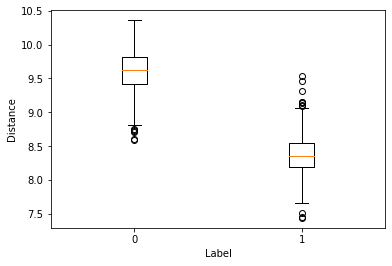

2.0627062706270682


In [3]:
# 단일 발화 EER - original

d0_same = []
d0_diff = []
for spk in spk_list:
    # same spk
    emb_mat = spk_emb_dict[spk]
    indices = random.sample(range(emb_mat.shape[0]), 2)
    emb1 = emb_mat[indices[0]]
    emb2 = emb_mat[indices[1]]
    d0_same.append(torch.cdist(emb1, emb2, p=2).mean().item())
    
    # diff spk
    indices = random.sample(spk_list, 2)
    emb_mat1 = spk_emb_dict[indices[0]]
    emb_mat2 = spk_emb_dict[indices[1]]
    emb1 = random.choice(emb_mat1)
    emb2 = random.choice(emb_mat2)
    d0_diff.append(torch.cdist(emb1, emb2, p=2).mean().item())


fig, ax = plt.subplots()
plt.boxplot([d0_same, d0_diff], positions=[1,0])
ax.set_xlabel('Label')
ax.set_ylabel('Distance')
plt.show()

d0 = d0_same + d0_diff
s0 = [-1*i for i in d0]
label_same = np.ones(len(d0_same))
label_diff = np.zeros(len(d0_diff))
label = list(np.concatenate([label_same, label_diff]))
(tt0, eer0, fpr0, fnr0) = tuneThreshold.tuneThresholdfromScore(s0, label, [1, 0.1])
print(eer0)

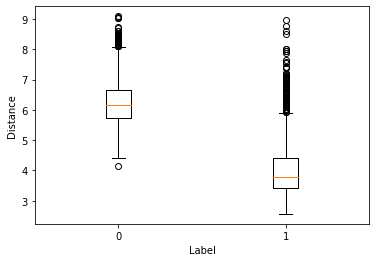

11.798679867986795


In [6]:
# 단일 발화 EER

d1_same = []
d1_diff = []
for spk in spk_list:
    # same spk
    emb_mat = spk_emb_dict[spk].mean(dim=1) # (speech #, 10, 512)
    indices = random.sample(range(emb_mat.shape[0]), 2)
    emb1 = emb_mat[indices[0]]
    emb2 = emb_mat[indices[1]]
    d1_same.append(torch.dist(emb1, emb2, p=2))
    
    # diff spk
    indices = random.sample(spk_list, 2)
    emb_mat1 = spk_emb_dict[indices[0]].mean(dim=1)
    emb_mat2 = spk_emb_dict[indices[1]].mean(dim=1)
    emb1 = random.choice(emb_mat1)
    emb2 = random.choice(emb_mat2)
    d1_diff.append(torch.dist(emb1, emb2, p=2))

fig, ax = plt.subplots()
plt.boxplot([d1_same, d1_diff], positions=[1,0])
ax.set_xlabel('Label')
ax.set_ylabel('Distance')

plt.show()

d1 = d1_same + d1_diff
s1 = [-1*i for i in d1]
label_same = np.ones(len(d1_same))
label_diff = np.zeros(len(d1_diff))
label = list(np.concatenate([label_same, label_diff]))
(tt1, eer1, fpr1, fnr1) = tuneThreshold.tuneThresholdfromScore(s1, label, [1, 0.1])
print(eer1)

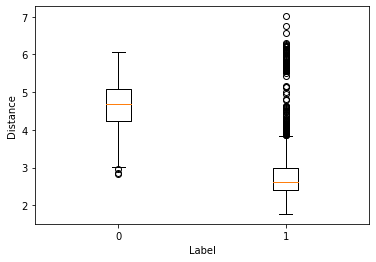

10.891089108910892


In [7]:
# 다발화 - single vector EER
d2_same = []
d2_diff = []
for spk in spk_list:
    # same spk
    emb_mat = spk_emb_dict[spk].mean(dim=1)
    index = random.choice(range(emb_mat.shape[0]))
    indices = list(range(emb_mat.shape[0]))
    indices.remove(index)
    emb1 = emb_mat[index]
    emb2 = torch.index_select(emb_mat, dim=0, index=torch.tensor(indices))
    emb2 = torch.mean(emb2, dim=0)
    d2_same.append(torch.dist(emb1, emb2, p=2))
    
    # diff spk
    indices = random.sample(spk_list, 2)
    emb1 = spk_emb_dict[indices[0]].mean(dim=1)
    emb2 = spk_emb_dict[indices[1]].mean(dim=1)
    emb1 = torch.mean(emb1, dim=0)
    emb2 = torch.mean(emb2, dim=0)
    # print(emb1.shape, emb2.shape)
    d2_diff.append(torch.dist(emb1, emb2, p=2))
    # break
    
fig, ax = plt.subplots()
plt.boxplot([d2_same, d2_diff], positions=[1,0])
ax.set_xlabel('Label')
ax.set_ylabel('Distance')
plt.show()


d2 = d2_same + d2_diff
s2 = [-1*i for i in d2]
label_same = np.ones(len(d2_same))
label_diff = np.zeros(len(d2_diff))
label = list(np.concatenate([label_same, label_diff]))
(tt2, eer2, fpr2, fnr2) = tuneThreshold.tuneThresholdfromScore(s2, label, [1, 0.1])
print(eer2)

In [ ]:
# 다발화 - matrix EER -> 다른 화자면 그냥 하면 되는데, 단일 화자에서 두개의 matrix를 어떻게 뽑아야 할까
# 이 경우 다발화 matrix를 만들 때 화자의 모든 발화를 쓰면 안됨. 부분적으로 사용해야 함